In [1]:
import torch
import pandas as pd
import numpy as np
import sklearn
from collections import Counter

In [2]:
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
from itertools import combinations

In [46]:
import re
import os

In [5]:
import torch.nn as nn

# Data Loading

In [6]:
path = "data/twitter.csv"
df = pd.read_csv(path, index_col=0)
df = df.rename(columns={'class': 'label'})
df.head()

,count,hate_speech,offensive_language,neither,label,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


1    19190
2     4163
0     1430
Name: label, dtype: int64


array([<AxesSubplot:ylabel='label'>], dtype=object)

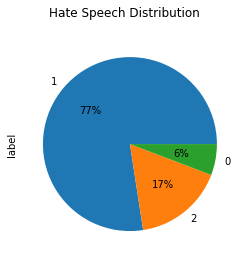

In [7]:
print(df.label.value_counts())
df.label.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Hate Speech Distribution')

## Data Cleansing

In [8]:
def filter_hatespeech_tweets(df):
    
    def filter_tweets(tweet):
        tweet = re.sub('@.\:|!|@\w+|&#[0-9]*;|#\w+|RT|\/\/t.co\/\w+|&gt|&lt', '', tweet)
        if tweet[0:4] == '  : ':
            tweet = tweet[4:]
        return tweet

    df['tweet'] = df['tweet'].apply(filter_tweets)
    df.replace("", np.nan, inplace=True)
    df = df.dropna()
    
    return df

In [9]:
df = filter_hatespeech_tweets(df)
df = filter_hatespeech_tweets(df)

In [10]:
df.head()

,count,hate_speech,offensive_language,neither,label,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about cleani...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,Dawg : You ever fuck a bitch and she start...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or it...


## Data Splitting

In [11]:
def split_dataset(df, seed, test_size):
    train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    return train.tweet.values, train.label.values, test.tweet.values, test.label.values

In [12]:
#categories = ['hate speech', 'offensive language', 'neither']
categories = [0,1,2]
seed = 11
test_size = 0.2

In [13]:
train, train_targets, test, test_targets = split_dataset(df, seed=seed, test_size=test_size)

In [14]:
train_size = len(train)
test_size = len(test)

In [15]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1]], [s.index[2], s[2]]

In [16]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)

In [17]:
train_ds = Bunch(data=train, target=train_targets)
test_ds = Bunch(data=test, target=test_targets)

## Buidling the Model

In [18]:
# Getting all the vocabularies and indexing to a unique position
vocab = Counter()
#Indexing words from the training data
for text in train_ds.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1

#Indexing words from the training data
for text in test_ds.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1

total_words = len(vocab)

def get_word_2_index(vocab):
    word2index = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i

    return word2index

word2index = get_word_2_index(vocab)

In [42]:
print(len(word2index))
print(word2index["the"]) # Showing the index of 'the'
print (total_words)

31465
14248
31465


In [20]:
# define the network
class News_20_Net(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(News_20_Net, self).__init__()
        self.layer_1 = nn.Linear(input_size,hidden_size, bias=True).cuda()
        self.relu = nn.ReLU().cuda()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True).cuda()
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True).cuda()
    # accept input and return an output
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [21]:
def get_batch(df,i,batch_size):
    batches = []
    results = []
    # Split into different batchs, get the next batch 
    texts = df.data[i*batch_size:i*batch_size+batch_size]
    # get the targets 
    categories = df.target[i*batch_size:i*batch_size+batch_size]
    #print(categories)
    for text in texts:
        # Dimension, 196609
        layer = np.zeros(total_words,dtype=float)

        for word in text.split(' '):
            layer[word2index[word.lower()]] += 1
        batches.append(layer)

    # We have 5 categories
    for category in categories:
        #print(category)
        index_y = -1
        if category == 0:
            index_y = 0
        elif category == 1:
            index_y = 1
        elif category == 2:
            index_y = 2
        results.append(index_y)

    # the training and the targets
    return np.array(batches),np.array(results)

In [22]:
# Parameters
learning_rate = 0.001
num_epochs = 8
batch_size = 32
display_step = 10 # ADDED will multiplied by 10

# Network Parameters
hidden_size = 100      # 1st layer and 2nd layer number of features
input_size = total_words # Words in vocab
num_classes = len(categories)         # Categories: "graphics","space","baseball","guns", "christian"

## Training

In [23]:
results = []

In [24]:
news_net = News_20_Net(input_size, hidden_size, num_classes)
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # This includes the Softmax loss function
optimizer = torch.optim.Adam(news_net.parameters(), lr=learning_rate)  

# Train the Model
for epoch in range(num_epochs):
    # determine the number of min-batches based on the batch size and size of training data
    total_batch = int(len(train_ds.data)/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train_ds,i,batch_size)
        
        articles = torch.cuda.FloatTensor(batch_x, device='cuda')
        labels = torch.cuda.LongTensor(batch_y, device='cuda')

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = news_net(articles)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % display_step == 0:
            result = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f'%(epoch+1, num_epochs, i+1, len(train_ds.data)/batch_size, loss.data)
            results.append({'Epoch': epoch+1, 'Step': i+1, 'Loss': loss.data.item()})
            if (i+1) % (display_step*10) == 0:
                print({'Epoch': epoch+1, 'Step': i+1, 'Loss': loss.data.item()})

{'Epoch': 1, 'Step': 100, 'Loss': 0.40492215752601624}
{'Epoch': 1, 'Step': 200, 'Loss': 0.6139299273490906}
{'Epoch': 1, 'Step': 300, 'Loss': 0.4984530508518219}
{'Epoch': 1, 'Step': 400, 'Loss': 0.5472877621650696}
{'Epoch': 1, 'Step': 500, 'Loss': 0.4438815712928772}
{'Epoch': 1, 'Step': 600, 'Loss': 0.2959631383419037}
{'Epoch': 2, 'Step': 100, 'Loss': 0.15201489627361298}
{'Epoch': 2, 'Step': 200, 'Loss': 0.4123905599117279}
{'Epoch': 2, 'Step': 300, 'Loss': 0.20588093996047974}
{'Epoch': 2, 'Step': 400, 'Loss': 0.26602521538734436}
{'Epoch': 2, 'Step': 500, 'Loss': 0.37290701270103455}
{'Epoch': 2, 'Step': 600, 'Loss': 0.06258188188076019}
{'Epoch': 3, 'Step': 100, 'Loss': 0.0718257874250412}
{'Epoch': 3, 'Step': 200, 'Loss': 0.3547375202178955}
{'Epoch': 3, 'Step': 300, 'Loss': 0.06800403445959091}
{'Epoch': 3, 'Step': 400, 'Loss': 0.06273873895406723}
{'Epoch': 3, 'Step': 500, 'Loss': 0.19478625059127808}
{'Epoch': 3, 'Step': 600, 'Loss': 0.038281798362731934}
{'Epoch': 4, 'Ste

## Validation

In [25]:
# Test the Model
correct = 0
total = 0
total_test_data = len(test_ds.target)

In [26]:
iterates = total_test_data/batch_size # ignore last (<batch_size) batch

In [27]:
all_total = []
all_correct = []
labels_all = []
predicted_all = []

In [28]:
for i in range(int(iterates)):
    batch_x_test,batch_y_test = get_batch(test_ds,i,batch_size)
    articles = torch.FloatTensor(batch_x_test).to('cuda')
    labels = torch.LongTensor(batch_y_test).to('cuda')
    outputs = news_net(articles)
    _, predicted = torch.max(outputs.data, 1)
    
    labels_all.extend([x.item() for x in labels])
    predicted_all.extend([x.item() for x in predicted])

In [29]:
categories = ['hate speech', 'offensive language', 'neither']

In [30]:
report = classification_report(labels_all, predicted_all, target_names=categories, output_dict=True)

In [31]:
df_report = pd.DataFrame(report).transpose()

In [32]:
df_report

,precision,recall,f1-score,support
hate speech,0.422460,0.263333,0.324435,300.000000
offensive language,0.905354,0.932323,0.918641,3827.000000
neither,0.758750,0.757803,0.758276,801.000000
accuracy,0.863231,0.863231,0.863231,0.863231
macro avg,0.695521,0.651153,0.667117,4928.000000
weighted avg,0.852128,0.863231,0.856402,4928.000000


In [33]:
df_results = pd.DataFrame(results)

In [34]:
df_results['learning_rate'] = learning_rate
df_results['num_epochs'] = num_epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] = num_classes
df_results['test_size'] = test_size
df_results['train_size'] = train_size
df_results['seed'] = seed
df_results['test_size'] = test_size
df_results['train_class_proportion_' + categories[0]] = round(train_class_distribution[0][1], 2)
df_results['train_class_proportion_' + categories[1]] = round(train_class_distribution[1][1], 2)
df_results['train_class_proportion_' + categories[2]] = round(train_class_distribution[2][1], 2)
df_results['test_class_proportion_' + categories[0]] = round(test_class_distribution[0][1], 2)
df_results['test_class_proportion_' + categories[1]] = round(test_class_distribution[1][1], 2)
df_results['test_class_proportion_' + categories[2]] = round(test_class_distribution[2][1], 2)

In [35]:
df_results.head()

,Epoch,Step,Loss,learning_rate,num_epochs,batch_size,num_classes,test_size,train_size,seed,train_class_proportion_hate speech,train_class_proportion_offensive language,train_class_proportion_neither,test_class_proportion_hate speech,test_class_proportion_offensive language,test_class_proportion_neither
0,1,10,0.997828,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
1,1,20,0.756163,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
2,1,30,0.694793,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
3,1,40,0.642377,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
4,1,50,0.728543,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16


In [36]:
name = 'training_logs_word_embedding_twitter.csv'

In [37]:
df_results.to_csv(name)

In [40]:
name = 'matrix_report_twitter.csv'

In [41]:
df_report.to_csv(name)

----

## Classication of Movies

### Load Movies

In [47]:
def read_movie_files(pathes):
    result = []
    for path in pathes: 
        directory = os.fsencode(path)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)

            if filename.endswith(".csv"):
                #print(os.path.join(directory, filename))
                #local_df = read_content(path + '//' + filename)
                movie_df = pd.read_csv(path + '//' + filename)
                tag = path.split('/')[1]
                count_utterances = movie_df.shape[0]
                result.append({'movie_name': filename[:-9], 'count_utterances': count_utterances, 'tag': tag, 'path': path + '//' + filename})
    result_df = pd.DataFrame(result)
    return result_df

In [48]:
pathes = ['movies/racism', 'movies/hate_speech', 'movies/friendship']

In [49]:
movie_metadata_df = read_movie_files(pathes)

In [50]:
movie_metadata_df.head()

,movie_name,count_utterances,tag,path
0,12 Angry Men,2065,racism,movies/racism//12 Angry Men_conv.csv
1,12 Years a Slave,110,racism,movies/racism//12 Years a Slave_conv.csv
2,42,1288,racism,movies/racism//42_conv.csv
3,A Bronx Tale,1961,racism,movies/racism//A Bronx Tale_conv.csv
4,A Time to Kill,2219,racism,movies/racism//A Time to Kill_conv.csv


array([<AxesSubplot:ylabel='tag'>], dtype=object)

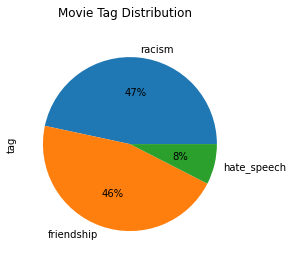

In [51]:
movie_metadata_df.tag.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Movie Tag Distribution')

In [52]:
movie_path = 'movies/racism/12 Years a Slave_conv.csv'

In [53]:
def annotate_single_movie(movie_df):
    utterances = movie_df.dialog.values
    batch = []
    for text in utterances:
        # Dimension, 196609
        layer = np.zeros(total_words,dtype=float)

        for word in text.split(' '):
            layer[word2index[word.lower()]] += 1
        batch.append(layer)
        
    texts = torch.FloatTensor(batch).to('cuda')
    print(texts)
    # labels = torch.LongTensor(batch_y_test).to('cuda')
    outputs = news_net(texts)
    _, predicted = torch.max(outputs.data, 1)
    predicted_all.extend([x.item() for x in predicted])

    return movie_df

In [54]:
movie_df = pd.read_csv('movies/racism/12 Angry Men_conv.csv')

In [55]:
movie_df.head()

,Unnamed: 0,dialog
0,0,"Thank you very much, sir."
1,1,You did a wonderful job. Wonderful.
2,2,Shh. Shh.
3,3,"We did it, Pete. We did it."
4,4,"For a moment, we had our doubts."


In [56]:
annotate_single_movie(movie_df)

KeyError: 'shh.'